In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from time import time
from google.colab import files

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link_train = 'https://drive.google.com/open?id=1wocSG9KQQRB9VvfFceYoWB8gAH0MoFAV'
fluff, id1 = link_train.split('=')
print (id1) # Verify that you have everything after '='

1wocSG9KQQRB9VvfFceYoWB8gAH0MoFAV


In [0]:
downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('dataset_05.csv') 

In [5]:
link_test = 'https://drive.google.com/open?id=1bOj5vMjlTnMTEBNImASqwXuHiJ0WB2ab'
fluff, id2 = link_test.split('=')
print (id2) # Verify that you have everything after '='

1bOj5vMjlTnMTEBNImASqwXuHiJ0WB2ab


In [0]:
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('finaltest.csv') 

In [0]:
columns = ['','text_final','polarity','VADER_score','VADER_binary']

train = pd.read_csv('dataset_05.csv',
                     header = 0,
                     names = columns,
                     usecols = [1,2],
                     encoding ='ISO-8859-1')

In [0]:
columns_test = ['','text_no_tag','polarity','length']
test = pd.read_csv('finaltest.csv',
                     usecols = [1,2],
                     header = 0,
                     names = columns_test,
                     encoding ='ISO-8859-1')

In [9]:
len_train = len(train)
print("len training: " , len_train)
len_test = len(test)
print("len test: " , len_test)

len training:  602766
len test:  359


In [10]:
test.head()

,text_no_tag,polarity
0,@USER i love my kindle2 . not that the is co...,4
1,reading my kindle2 . love it . lee childs is...,4
2,"ok , first assesment of the kindle 2 . it fuc...",4
3,@USER you will love your kindle2 . i have had ...,4
4,@USER fair enough . but i have the kindle2 and...,4


In [0]:
test['polarity'].replace(to_replace=[4],value=1,inplace=True)

In [12]:
test.head()

,text_no_tag,polarity
0,@USER i love my kindle2 . not that the is co...,1
1,reading my kindle2 . love it . lee childs is...,1
2,"ok , first assesment of the kindle 2 . it fuc...",1
3,@USER you will love your kindle2 . i have had ...,1
4,@USER fair enough . but i have the kindle2 and...,1


In [13]:
print("n positive tweets:   ", len(train[train['polarity'] == 0]))
print("n negative tweets:   ", len(train[train['polarity'] == 1]))
print("size positive tweets:   ", train[train['polarity'] == 0].size)
print("size negative tweets:   ", train[train['polarity'] == 1].size)

n positive tweets:    253678
n negative tweets:    349088
size positive tweets:    507356
size negative tweets:    698176


In [14]:
train.head()

,text_final,polarity
0,is upset that he can not update his facebook b...,0
1,"@USER no , it ' s not behaving at all . i am m...",0
2,@USER hey long time no see ! yes . rains a bi...,0
3,@USER i could not bear to watch it . and i tho...,0
4,hollis ' death scene will hurt me severely to ...,0


In [0]:
train.rename(columns={'text_final':'text_no_tag'},inplace=True)

In [16]:
train.head()

,text_no_tag,polarity
0,is upset that he can not update his facebook b...,0
1,"@USER no , it ' s not behaving at all . i am m...",0
2,@USER hey long time no see ! yes . rains a bi...,0
3,@USER i could not bear to watch it . and i tho...,0
4,hollis ' death scene will hurt me severely to ...,0


In [0]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(train['text_no_tag'])
sequences = tokenizer.texts_to_sequences(train['text_no_tag'])
X = pad_sequences(sequences, maxlen=50)


In [18]:
print(X.shape[1])

50


In [19]:
link_test = 'https://drive.google.com/open?id=1nYzhX_ENqx3OJFuinbeYcwflfqa7dxMm'
fluff, id3 = link_test.split('=')
print (id3) # Verify that you have everything after '='

1nYzhX_ENqx3OJFuinbeYcwflfqa7dxMm


In [20]:
downloaded3 = drive.CreateFile({'id':id3}) 
downloaded3.GetContentFile('glove.twitter.27B.50d.txt')
print(id3)

1nYzhX_ENqx3OJFuinbeYcwflfqa7dxMm


In [0]:
embeddings_index = dict()
f = open('glove.twitter.27B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [23]:

from keras.layers import Bidirectional

embed_dim = 50
lstm_out = 10

model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim, weights=[embedding_matrix], input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(CuDNNLSTM(lstm_out)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                4960      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
Total params: 1,005,002
Trainable params: 1,005,002
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
Y = pd.get_dummies(train['polarity']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(403853, 50) (403853, 2)
(198913, 50) (198913, 2)


In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

plt.style.use('ggplot')

batch_size = 32
checkpoint = ModelCheckpoint('model_w_embeddings.h5', monitor='val_loss', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, patience=15, verbose=1
)
#files.download("model_w_embeddings.h5")
callbacks_list = [checkpoint, early_stopping]
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=20, batch_size=batch_size, verbose=2, callbacks=callbacks_list)

Train on 323082 samples, validate on 80771 samples
Epoch 1/20
 - 216s - loss: 0.4157 - acc: 0.8082 - val_loss: 0.3635 - val_acc: 0.8381

Epoch 00001: val_loss improved from inf to 0.36352, saving model to model_w_embeddings.h5
Epoch 2/20
 - 214s - loss: 0.3645 - acc: 0.8380 - val_loss: 0.3572 - val_acc: 0.8429

Epoch 00002: val_loss improved from 0.36352 to 0.35716, saving model to model_w_embeddings.h5
Epoch 3/20
 - 210s - loss: 0.3494 - acc: 0.8451 - val_loss: 0.3477 - val_acc: 0.8460

Epoch 00003: val_loss improved from 0.35716 to 0.34765, saving model to model_w_embeddings.h5
Epoch 4/20
 - 211s - loss: 0.3388 - acc: 0.8514 - val_loss: 0.3468 - val_acc: 0.8471

Epoch 00004: val_loss improved from 0.34765 to 0.34684, saving model to model_w_embeddings.h5
Epoch 5/20
 - 210s - loss: 0.3301 - acc: 0.8555 - val_loss: 0.3493 - val_acc: 0.8475

Epoch 00005: val_loss did not improve from 0.34684
Epoch 6/20
 - 210s - loss: 0.3242 - acc: 0.8585 - val_loss: 0.3491 - val_acc: 0.8476

Epoch 0000

In [0]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.8603
Testing Accuracy:  0.8482


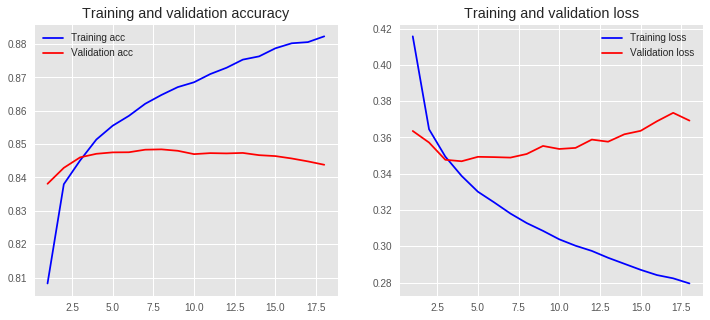

In [28]:
from keras.engine.saving import load_model

model = load_model('model_w_embeddings.h5')

loss, accuracy = model.evaluate(X_train, Y_train, verbose=2, batch_size=batch_size)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [29]:
twt = ['@USER i love  my kindle2 . not that the  is cool , but the  is fantastic in its own right .']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
print(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=50)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(np.argmax(sentiment) == 1):
    print("positive")
elif (np.argmax(sentiment) == 0):
    print("negative")

[[2, 1, 23, 9, 12, 19, 3, 11, 155, 24, 3, 11, 581, 15, 72, 519, 124]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   1  23
    9  12  19   3  11 155  24   3  11 581  15  72 519 124]]
[0.05692359 0.9456686 ]
positive


In [30]:
#model = load_model('model_w_embeddings.h5')
sentiment_predicted = []
for tweet in test['text_no_tag']:
    print(tweet)
    tweet = tokenizer.texts_to_sequences([tweet])
    print(tweet)
    #set maxlen as embedding_1 (find it in: embedding_1 (Embedding)      (None, 53, 128)           256000)
    tweet = pad_sequences(tweet, maxlen=50, dtype='int32', value=0)
    print(tweet)
    sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
    #print(tweet)
    print(sentiment)
    sentiment_predicted.append(np.argmax(sentiment))

print(sentiment_predicted)

@USER i love  my kindle2 . not that the  is cool , but the  is fantastic in its own right .
[[2, 1, 23, 9, 12, 19, 3, 11, 155, 24, 3, 11, 581, 15, 72, 519, 124]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   1  23
    9  12  19   3  11 155  24   3  11 581  15  72 519 124]]
[0.05692359 0.9456686 ]
reading my kindle2 .  love it .  lee childs is good read .
[[508, 9, 23, 8, 2514, 11, 25, 352]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   508    9   23    8 2514   11   25  352]]
[0.01914593 0.9815137 ]
ok , first assesment of the kindle 2 .  it fucking rocks ! 
[[152, 192, 17, 3, 7151, 208, 8, 524, 1328]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   

In [31]:
test['polarity_nn'] = sentiment_predicted

test.head()

,text_no_tag,polarity,polarity_nn
0,@USER i love my kindle2 . not that the is co...,1,1
1,reading my kindle2 . love it . lee childs is...,1,1
2,"ok , first assesment of the kindle 2 . it fuc...",1,1
3,@USER you will love your kindle2 . i have had ...,1,0
4,@USER fair enough . but i have the kindle2 and...,1,1


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [33]:
print("Accuracy sore: ", accuracy_score(test['polarity'], test['polarity_nn']))
print("Precision score: ", precision_score(test['polarity'], test['polarity_nn'], average='binary'))
print("Recall score: ", recall_score(test['polarity'], test['polarity_nn'], average='binary'))
print("F-measure score: ", f1_score(test['polarity'], test['polarity_nn'], average='binary'))

Accuracy sore:  0.8467966573816156
Precision score:  0.8324607329842932
Recall score:  0.8736263736263736
F-measure score:  0.8525469168900804


In [34]:
test.tail()

,text_no_tag,polarity,polarity_nn
354,"after using latex a lot , any other typeset ma...",1,0
355,"on that note , i hate word . i hate pages . i ...",0,0
356,ah . back in a *real* text editing environme...,1,1
357,"trouble in iran , i see . hmm . iran . iran so...",0,0
358,reading the tweets coming out of iran . the w...,0,0


In [35]:
print("positive polarity: ", len(test[test['polarity']==1]))
print("negative polarity: ", len(test[test['polarity']==0]))
print("positive polarity_nn: ", len(test[test['polarity_nn']==1]))
print("negative polarity_nn: ", len(test[test['polarity_nn']==0]))

positive polarity:  182
negative polarity:  177
positive polarity_nn:  191
negative polarity_nn:  168


In [0]:

test.to_csv('predicted_test.csv')
files.download("predicted_test.csv")